# Multi Layer Perceptron from Scratch

### Cristiano De Nobili - My Contacts
For any questions or doubts you can find my contacts here:

<p align="center">

[<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/e/e7/Instagram_logo_2016.svg/2048px-Instagram_logo_2016.svg.png" width="20">](https://www.instagram.com/denocris/?hl=it)
[<img src="https://1.bp.blogspot.com/-Rwqcet_SHbk/T8_acMUmlmI/AAAAAAAAGgw/KD_fx__8Q4w/s1600/Twitter+bird.png" width="30">](https://twitter.com/denocris) 
[<img src="https://loghi-famosi.com/wp-content/uploads/2020/04/Linkedin-Simbolo.png" width="40">](https://www.linkedin.com/in/cristiano-de-nobili/)     

</p>

or here (https://denocris.com).

### Useful Links

All notebooks can be found [here!](https://drive.google.com/drive/folders/1i3cNfzWZTNXfvkFVVIIDXjRDdSa9L9Dv?usp=sharing)

Introductory slides [here!](https://www.canva.com/design/DAEa5hLfuWg/-L2EFFfZLVuiDkmg4KiKkQ/view?utm_content=DAEa5hLfuWg&utm_campaign=designshare&utm_medium=link&utm_source=publishsharelink)

Collection of references: [here!](https://denocris.notion.site/Deep-Learning-References-0c5af2dc5c8d40baba19f1328d596fff)


### Packages

In [3]:
%matplotlib inline

import random
import numpy as np
from matplotlib import pyplot as plt


import torch
import torch.nn as nn
from torchsummary import summary
from torch.utils.data import DataLoader, TensorDataset

In [11]:
#device = torch.device('cpu')
#device = torch.device('cuda') # Uncomment this to run on GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [8]:
!nvidia-smi

/bin/bash: nvidia-smi: command not found


### Notebook Outline

* Multi Layer Perceptron (aka Dense Layer, Fully-connected) with nn.Modules
* Custimization
* Multi Layer Perceptron with Sequential

### Activation Functions


To solve non-linear problems (99% of real-world problems) we need non-linear activation functions. There are plenty of activation functions in the literature. The choice of the more suited activation function for a network or a specific layer depends on many factors, such as the task itself. In this course, we will not deal with these design settings. For this exercise, we will use some common choice: *logistic sigmoid activation function* and *hyperbolic tangent activation function*. They have similar properties and, for this reason, the latter is often called *scaled sigmoid*. 

These functions:

* are non linear in nature;

* they have activations bounded;

* between $x$ values $-2$ to $2$, $y$ values are very steep. Which means, any small changes in the values of $x$ in that region will cause values of $y$ to change significantly. Outside this range, $y$ values tend to respond very less to changes in $x$. This can cause an effect named *vanishing of gradients*;

* tend to bring the activations to either side of the curve. In particular when used in the last layer, they are suited for binary classifiation problems making clear distinctions on prediction.


We will also consider the widely used *ReLu activation* (Rectified Linear Unit). It is also a non-linear function, but it is not bounded. This means it can blow up the activation. Moreover, it is worth highlighting the sparsity of its activation. If we consider a neural network with a lot of neurons, using a *sigmoid* or *tanh* will cause almost all neurons to fire in an analog way. That means almost all activations will be taken into account and processed to describe the output of a network. We say that the activation is dense. This could be costly. Ideally, we would want a few neurons in the network to not activate and thereby making the activations sparse and efficient.


Logistic regression is usually used as a binary classification model instead of a regression model. In this setting, we suppose we have two destination classes to which we assign values 0 and 1: $y ∈ {0, 1}$. Since the codomain of the sigmoid is $[0,1]$, we can interpret its output $ŷ$ as a probability value, and assign each data to the class 0 if $ŷ <= 0.5$, to the class 1 otherwise.


In [6]:
# Scaled Sigmoid Activation Function
def tanh(x):
    return np.tanh(x)
# Its derivative
def d_tanh(x):
    return 1 - np.tanh(x) ** 2

# Logistic Activation Function, also called Sigmoid
# (is this one torch.nn.functional.sigmoid)
def logistic(x):
    return 1/(1 + np.exp(-1*x))
# Its derivative
def d_logistic(x):
    return logistic(x) * ( 1 - logistic(x) )

# ReLu Activation Function
def relu(x):
  return (np.abs(x) + x)*0.5
# Its derivative
def d_relu(x):
    x = np.array(x)
    return np.where(x > 0, 1, 0)

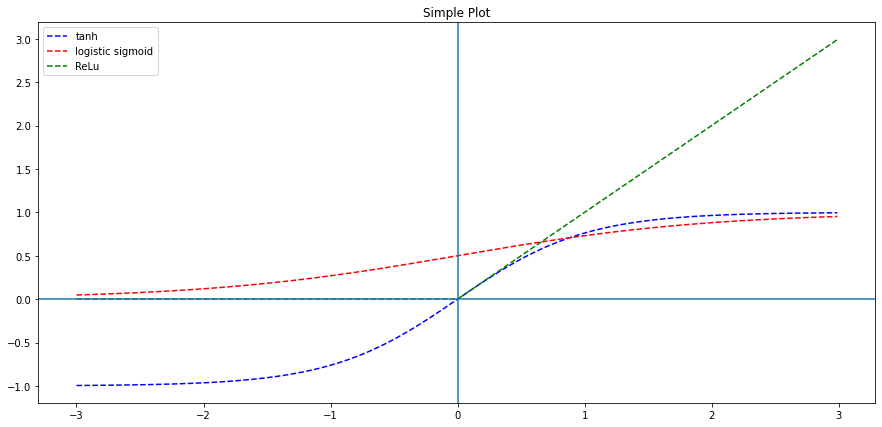

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15,7))

# evenly sampled time at 200ms intervals
t = np.arange(-3., 3., 0.01)

# red dashes, blue squares and green triangles
plt.plot(t, tanh(t), 'b--', label='tanh')
plt.plot(t, logistic(t), 'r--', label='logistic sigmoid')
plt.plot(t, relu(t), 'g--', label='ReLu')


plt.title("Simple Plot")

plt.axvline(0)
plt.axhline(0)

plt.legend()
plt.show()

### Parameters vs Hyperparameters

It is important to distinguish:

* **parameters** (they are learned during training): weights and biases of a DNN which transform the input before applying the activation function. Each layer has its own set of parameters. The parameters are adjusted through backpropagation to minimize the loss function or in other words are learned during the training process;

* **hyperparameters:** unlike parameters, their values are not adapted by the learning algorithm itself. They can be viewed as settings that can be used to control the behaviour of the algorithm. Different hyperparameter values can impact model training and convergence rates. Examples are number of layers, type of architecture, batch size, learning rate, etc...;


### Fully-Connected Neural Network with PyTorch built-in nn.Modules

The MLP is a family of Artificial NNs in which the input is a vector of size $ℝ^d$ and the output is again a vector of size $ℝ^p$, where p is determined upon the nature of the problem we wish to solve (for instance it might be the number of classes). Additionally, a MLP is characterized by multiple stages (layers) of sequential vector-matrix multiplication and non-linearity in which each output of the layer $l-1$ acts as input to the layer $l$.


In NNs, each of the nodes within the graph is called a **neuron**. They are organized in **layers**. The first layer is called **input layer** and represents the dimensions of our data. The last layer is called output layer and represent the **output** of our NN. The intermediate layers are called **hidden layers**. 
If the NN is an MLP, each neuron in a given layer (except for the input) receives information from every neuron of the previous; moreover, each neuron in any layer (except for the output) sends information to every neuron of the next layer. There is no communication between neurons of the same layer (This happens in Recursive NNs such as Recurret NNs).

In [12]:
# Set a seed for reproducibility
torch.manual_seed(172) 


n = 1000 # n.of data samples (it will be the batch size)

din = 100 # input dimension (think a 10x10 image flattened)
dh = 30 # hidden layer dimension
dout = 10 # output dimension (think the label as a 10-dim vector)

# create random tensors
x = torch.randn(n, din, device=device)   # data samples
y = torch.randn(n, dout, device=device)  # data labels (think the label as a 10-dim vector)

print(x.shape, y.shape)

torch.Size([1000, 100]) torch.Size([1000, 10])


We define our neural network by subclassing `nn.Modules`. This way to define a NN it allows us to better customize our model. Every nn.Module subclass implements the operations on input data in the forward method.


We will now be exploring built-in structures and routines supporting the creation of ML models.

Usually, a PyTorch model is a class inheriting from `torch.nn.Modules`. This way to define a NN it allows us to better customize our model. Inside `torch.nn.Modules` class, we'll define two methods:

* the constructor `(__init__)` in which we define the building blocks of our model as class variables 
* the `forward` method, which specifies how the data fed into the model needs to be processed in order to produce the output

We don't need to define backward methods since we're constructing our model with built-in PyTorch building blocks. PyTorch automatically creates a backward routine based upon the forward method.

Our model only has one building block (layer) which is a Linear layer. The Linear layer processes its input as $XW + b$ which is exactly the equation of a linear regressor. 
$$
\begin{pmatrix} 
w_{00} & w_{01} \\
w_{10} & w_{11} 
\end{pmatrix}\cdot
\begin{pmatrix} 
x_1  \\
x_2 
\end{pmatrix}
+
\begin{pmatrix} 
b_0  \\
b_1  
\end{pmatrix}
$$

For the moment we omit the bias term $b$.



In the code below, we need the super() call so that the nn.Module class itself is initialised: in Python, superclass constructors/initialisers aren't called automatically - they have to be called explicitly, and that is what super() does - it works out what superclass to call.

In [13]:
class Net(nn.Module):
    def __init__(self, din=100, dh=30, dout=10):
        super(Net, self).__init__()
        
        # I declare here what I need to construct my network
        
        self.lin1 = nn.Linear(in_features=din, out_features=dh, bias=False) # equivalent nn.Linear(din, dh)
        self.lin2 = nn.Linear(in_features=dh, out_features=dout, bias=False) # equivalent nn.Linear(dh, dout)
        # additional argument: requires_grad = True (default) to train params or false to freeze them
    
    def forward(self, x):
        
        # I specify in the forward-pass how to use the layers defined in __init__
        out = self.lin1(x)
        out = nn.functional.sigmoid(out)
        return self.lin2(out)
    
    #-----------------------------------------------------#
    #                   A custom method
    #-----------------------------------------------------#
    def extract_sigmoid(self,x):
        '''
        Extracts the activations of the hidden layer
        '''
       
        return nn.functional.sigmoid(self.lin1(x))

    #-----------------------------------------------------#
    #                   A custom method
    #-----------------------------------------------------#
    def extract_lin1(self,x):
        '''
        Extracts the activations of the hidden layer
        '''
       
        return self.lin1(x)

We can create an instance of `Net`.

In [14]:
model = Net(din,dh,dout).to(device)

In [15]:
input_size = (din,)
print(summary(model, input_size))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 30]           3,000
            Linear-2                   [-1, 10]             300
Total params: 3,300
Trainable params: 3,300
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.01
Estimated Total Size (MB): 0.01
----------------------------------------------------------------
None


/usr/local/lib/python3.9/site-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


We can also inspect the weights directly

In [16]:
for name, param in model.named_parameters():
    print(f"Layer: {name} | Size: {param.size()} | Values : {param[:2]} \n")

Layer: lin1.weight | Size: torch.Size([30, 100]) | Values : tensor([[ 0.0210, -0.0600, -0.0692,  0.0188,  0.0200,  0.0179, -0.0780,  0.0469,
          0.0704,  0.0265, -0.0144, -0.0427,  0.0366,  0.0311, -0.0473,  0.0551,
         -0.0926, -0.0466, -0.0397, -0.0257,  0.0725,  0.0486, -0.0796,  0.0547,
          0.0646, -0.0827,  0.0265,  0.0757, -0.0709,  0.0625, -0.0334,  0.0221,
          0.0212, -0.0058, -0.0642,  0.0880, -0.0183,  0.0894, -0.0458, -0.0207,
         -0.0169,  0.0337,  0.0076, -0.0185,  0.0782,  0.0701, -0.0098, -0.0417,
         -0.0745, -0.0189,  0.0479, -0.0044, -0.0563, -0.0708, -0.0957, -0.0340,
          0.0009, -0.0949, -0.0475,  0.0336,  0.0650, -0.0938, -0.0412, -0.0989,
          0.0833,  0.0955,  0.0559, -0.0291, -0.0131, -0.0059,  0.0343,  0.0472,
         -0.0394, -0.0284,  0.0963,  0.0096, -0.0521, -0.0054, -0.0993,  0.0396,
         -0.0114, -0.0956,  0.0292, -0.0873,  0.0209, -0.0537,  0.0323, -0.0825,
         -0.0903, -0.0794,  0.0465,  0.0068,  0.0

The model output. The `forward` method gets implicitly called by passing the data to our model's instance `model`:



In [17]:
y_pred = model(x)
print(f"Model output: {y_pred}")

Model output: tensor([[-0.3633,  0.1984, -0.1822,  ..., -0.0845,  0.3113, -0.3994],
        [-0.3418,  0.0673, -0.1222,  ..., -0.1107,  0.3431, -0.3490],
        [-0.3440, -0.0462, -0.1094,  ..., -0.1050,  0.2420, -0.3256],
        ...,
        [-0.2557,  0.0595, -0.1171,  ..., -0.0433,  0.3094, -0.3240],
        [-0.3783,  0.0620, -0.2360,  ..., -0.0493,  0.4284, -0.3136],
        [-0.5027, -0.0692, -0.0988,  ..., -0.0367,  0.3164, -0.3181]],
       grad_fn=<MmBackward0>)


We now can use the method extract, that allows us to see the output of layer 1

In [18]:
model.extract_lin1(x)

tensor([[ 0.1310,  0.3662, -0.7144,  ..., -0.5111,  0.1799, -0.6700],
        [ 0.1860,  0.1881,  0.1978,  ...,  0.6281,  0.5276, -0.3322],
        [ 0.7118,  0.0656,  0.6124,  ...,  1.1545, -0.1204,  0.0613],
        ...,
        [-0.0518, -0.1738,  0.0486,  ..., -0.6461, -0.3852,  0.7876],
        [-0.6596, -0.5374, -0.2872,  ..., -0.9003,  0.6188, -0.2885],
        [ 0.6269, -0.0714,  0.7675,  ...,  0.6671, -0.7698,  0.8136]],
       grad_fn=<MmBackward0>)

We can inspect the current parameters also by using the `state_dict` method, which prints the building blocks of our model and their current parameters. Note that state_dict is essentially a dictonary indexed by the names of the building blocks which we defined inside the constructor (plus some additional identifiers if a layer has more than one set of parameters). We will see later why the `state_dict` method is useful.

In [19]:
for param_name, param in model.state_dict().items():
    print(param_name, param)

lin1.weight tensor([[ 0.0210, -0.0600, -0.0692,  ..., -0.0098,  0.0882, -0.0977],
        [-0.0884, -0.0678, -0.0227,  ..., -0.0104,  0.0203, -0.0192],
        [ 0.0479,  0.0821, -0.0236,  ..., -0.0437,  0.0987, -0.0483],
        ...,
        [-0.0215,  0.0834, -0.0209,  ..., -0.0616, -0.0580, -0.0401],
        [ 0.0472,  0.0304,  0.0322,  ..., -0.0550, -0.0385,  0.0053],
        [-0.0520, -0.0351,  0.0898,  ..., -0.0045, -0.0752,  0.0914]])
lin2.weight tensor([[ 0.0102, -0.0405, -0.0604, -0.0850, -0.1278, -0.1810, -0.0805,  0.1816,
          0.0154, -0.1111,  0.1224, -0.0604, -0.0746,  0.0374, -0.1367,  0.0229,
         -0.0767, -0.0360, -0.1296, -0.1605,  0.1693,  0.0665,  0.0137, -0.1451,
         -0.1302,  0.1674,  0.1419,  0.0990,  0.0632, -0.1016],
        [-0.0323,  0.0882, -0.1100,  0.1274, -0.0328, -0.1815,  0.0758,  0.1198,
         -0.0169,  0.0435,  0.1380,  0.1027, -0.0130, -0.1049, -0.0511, -0.0474,
          0.1782,  0.0897, -0.1310, -0.1054,  0.1554, -0.0027, -0.1185, -

#### Saving and Loading Parameters

Let us suppose that we want to save model initial parameters to try than different experiments starting from the same initialization

In [20]:
import os
folder_save = "models/mlp_init"
os.makedirs(folder_save, exist_ok=True)
filename = os.path.join(folder_save, "model.pt")
torch.save(model.state_dict(), filename)

We initializate a new istance of the class `Net()`

In [21]:
model = Net(din,dh,dout).to(device)

model.extract_lin1(x)

tensor([[-0.3511, -0.1362,  0.4146,  ..., -0.7115, -0.2193,  1.3253],
        [-0.6890,  0.1434, -0.9978,  ..., -0.2381, -0.4271,  0.0582],
        [-0.1483, -0.6387,  0.0806,  ...,  0.4839,  0.2708, -0.8254],
        ...,
        [ 0.2625, -1.5232, -0.8773,  ..., -0.0379,  0.6632, -1.5393],
        [ 0.2188, -0.9119,  0.2753,  ...,  0.0763,  0.0330,  1.0157],
        [-1.0442, -1.0656, -0.3868,  ..., -0.6497, -0.6997, -0.6696]],
       grad_fn=<MmBackward0>)

Let us now suppos we wish to reload the `state_dict`

In [22]:
model.load_state_dict(torch.load(filename))

<All keys matched successfully>

In [23]:
model.extract_lin1(x)

tensor([[ 0.1310,  0.3662, -0.7144,  ..., -0.5111,  0.1799, -0.6700],
        [ 0.1860,  0.1881,  0.1978,  ...,  0.6281,  0.5276, -0.3322],
        [ 0.7118,  0.0656,  0.6124,  ...,  1.1545, -0.1204,  0.0613],
        ...,
        [-0.0518, -0.1738,  0.0486,  ..., -0.6461, -0.3852,  0.7876],
        [-0.6596, -0.5374, -0.2872,  ..., -0.9003,  0.6188, -0.2885],
        [ 0.6269, -0.0714,  0.7675,  ...,  0.6671, -0.7698,  0.8136]],
       grad_fn=<MmBackward0>)

Now, let's suppose we want to load into the model new weights (or pre-trained ones). For the sake of simplicity, we set them all to 1

In [24]:
l1_weights = torch.ones(din, dh)
l2_weights = torch.ones(dh, dout)

In [25]:
state_dict = model.state_dict()
state_dict["lin1.weight"] = l1_weights.T
state_dict["lin2.weight"] = l2_weights.T
model.load_state_dict(state_dict)

<All keys matched successfully>

In [26]:
model.extract_lin1(x)

tensor([[ 15.3878,  15.3878,  15.3878,  ...,  15.3878,  15.3878,  15.3878],
        [ -2.2439,  -2.2439,  -2.2439,  ...,  -2.2439,  -2.2439,  -2.2439],
        [-26.7902, -26.7902, -26.7902,  ..., -26.7902, -26.7902, -26.7902],
        ...,
        [  3.8349,   3.8349,   3.8349,  ...,   3.8349,   3.8349,   3.8349],
        [ -6.3877,  -6.3877,  -6.3877,  ...,  -6.3877,  -6.3877,  -6.3877],
        [-15.8279, -15.8279, -15.8279,  ..., -15.8279, -15.8279, -15.8279]],
       grad_fn=<MmBackward0>)

In [27]:
# check them
x.sum(dim=1)[:5]

tensor([ 15.3878,  -2.2439, -26.7902,  -4.3850,  19.8989])

#### The Loss Function

In [28]:
loss_fn = torch.nn.MSELoss(reduction='mean')

$$L(w) = \frac{1}{N} \Sigma_i |model(x_i, w) - y_i|^2$$

In [29]:
assert y.shape == y_pred.shape
loss = loss_fn(y_pred, y)
loss
loss.to('cpu')
print(loss.item())

1.0480272769927979


#### The Training Loop

Setup the training (learning) procedure:

0.   Define the neural network that has some learnable parameters, called weights;
2.   **Forward pass:** the input (or a batch of inputs) is processed through the network. The model makes a guess about the output.

3.   **Loss function evaluation:** Loss Function is computed on data at step N (how far is the output from being correct?);
4.   **Backward pass:** collects the derivatives of the loss function (gradients) with respect to its parameters (weights and bias);
5.   optimizes parameters using gradient descent. Update network params: $\theta_N = \theta_{N-1} - \alpha \frac{d L}{d \theta}$;

You can check out [here](https://www.youtube.com/watch?v=tIeHLnjs5U8) a video on backpropagation!

In [30]:
lr = 1e-4  # 0.1-0.000001
nepochs = 5000
training_loss = []

In [31]:
# Set the model to training phase (we will se more later on)
model.train()

for t in range(nepochs):
    
    y_pred = model(x)
    
    loss = loss_fn(y_pred, y)
    training_loss.append(loss.item())
    
    
    # ---------------------------------   Modification of the parameters due to the loss
    
    # Reset the gradients previously accumulated before running 
    # the backward pass. This will avoid re-using gradients from previous loops.
    # Later on we will zero_grad() the optimizer.
    model.zero_grad()

    # Backward pass: compute gradient of the loss with respect to all the learnable
    # parameters of the model. Internally, the parameters of each Module are stored
    # in Tensors with requires_grad=True, so this call will compute gradients for
    # all learnable parameters in the model. When you call backward 
    # the gradients of operands with requires_grad == True are calculated 
    # with respect to the tensor you called backward on.
    
    loss.backward()


    # Update the weights using gradient descent (almost manually). Each parameter is a Tensor, so
    # we can access its gradients like we did before. Later on we will use torch.optim!
    
    # torch.no_grad(): it temporarily sets all the requires_grad flag to false. If we omit it,
    # then weight update step will be added to the computation graph of the model which is not desired.
    # This will simply update their values without changing their gradients.
    
    with torch.no_grad():
        for param in model.parameters():
            param.data -= lr * param
            
    # This last passage can be done simply with (we will see it later on)
    # optimizer.step()



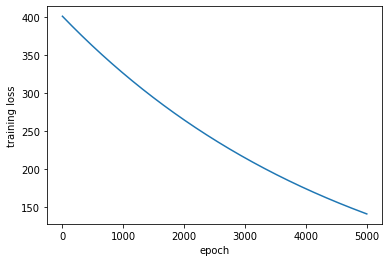

In [32]:
from matplotlib import pyplot as plt
plt.plot(training_loss,'-')
plt.xlabel('epoch')
plt.ylabel('training loss')
plt.show()

This example is meant just to illustrate the basic PyTorch machinery at work: it is not representative of true learning problems since there is no separate test set against which to evaluate the algorithm. 

### Model Customization

#### Custom Layers and Activation Function

Let us suppose we wish to build a custom layer 
to our network, for example, and for example a custom activation function. Subclassing `nn.Module` it is possibile.



In [53]:
# Custom Layer

class MyLinearLayer(nn.Module):
    """ Custom Linear layer"""
    # it needs to have at least a constructor and a forward method, just like an MLP
    def __init__(self, size_in = 100, size_out = 30):
        super(MyLinearLayer, self).__init__()

        self.size_in, self.size_out = size_in, size_out

        #define layer dimensions
        weights = torch.Tensor(size_in, size_out) 
        self.W = nn.Parameter(weights, requires_grad=True)
        #initilize weigths
        torch.nn.init.normal_(self.W, mean=0.0, std=1.0)

    def forward(self, x):
        out = torch.mm(x, self.W)
        return out 

In [54]:
weights = torch.Tensor(2, 2)
print(weights)
W = nn.Parameter(weights)
print(W)
torch.nn.init.normal_(W, mean=0.0, std=1.0)
print(W)

tensor([[ 0.0000e+00,  2.5244e-29],
        [ 7.9670e-17, -3.6902e+19]])
Parameter containing:
tensor([[ 0.0000e+00,  2.5244e-29],
        [ 7.9670e-17, -3.6902e+19]], requires_grad=True)
Parameter containing:
tensor([[-3.0982,  0.7360],
        [ 1.1214,  2.6428]], requires_grad=True)


In [55]:
# Custom Activation Function
class MySin(torch.nn.Module):
    """ Custom Linear layer"""
    def __init__(self): 
        super().__init__()
        # no additional stuff to do here as Sin has no additional parameters to set
    
    def forward(self, X):
        return torch.sin(X)

#### Custom Loss Function (TODO)

In [61]:
#TODO
# Custom Loss Function
class myLoss(torch.nn.Module):
    """ Custom Loss function"""
    def __init__(self, y_pred = 1, y_exact = 1): 
        super(myLoss, self).__init__()

        self.y_pred, self.y_exact = y_pred, y_exact
    
    def compute_loss(self):
        loss = np.sum((self.y_pred-self.y_exact)**2)/len(y_pred)
        return loss

In [62]:
myLoss1 = myLoss(np.array([[1, 1.5, 2]]), np.array([[1.001, 1.501, 2]]))
loss1 = myLoss1.compute_loss()
print(loss1)

1.9999999999995597e-09


#### Custom Model

In [63]:
class Net(nn.Module):
    def __init__(self, din, dh, dout):
        super(Net, self).__init__()
        
        # I declare here what I need to construct my network
        
        self.lin1 = MyLinearLayer(din, dh)
        self.lin2 = MyLinearLayer(dh, dout)
       
    
    def forward(self, x):
        
        # I specify in the forward-pass how to use the layers defined in __init__
        x = nn.functional.sigmoid(self.lin1(x)) 
        return self.lin2(x)
    
    def extract(self,x):
        '''
        Extracts the activations of the hidden layer
        '''
        return nn.functional.sigmoid(self.lin1(x))

In [64]:
n = 1000 # n.of data samples

din = 100 # input dimension
dh = 30 # hidden layer dimension
dout = 10 # output dimension

model = Net(din,dh,dout).to(device)

In [65]:
# Choose an optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
# optimizer = torch.optim.SGD(model.parameters(), lr=lr)

In [66]:
training_loss = []

for t in range(nepochs):
    
    # Compute prediction and loss
    y_pred = model(x)
    loss = loss_fn(y_pred, y)
    training_loss.append(loss.item())

    # Backpropagation
    optimizer.zero_grad()
    loss.backward()
    
    #with torch.no_grad():
    #    for param in model.parameters():
    #        param.data -= lr * param.grad
    optimizer.step()

/Users/MatteoSaccardi/opt/anaconda3/lib/python3.9/site-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


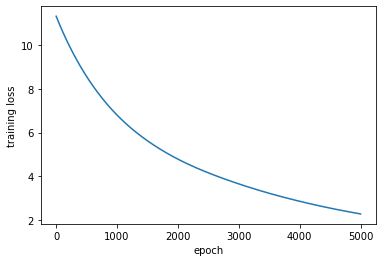

In [67]:
from matplotlib import pyplot as plt
plt.plot(training_loss,'-')
plt.xlabel('epoch')
plt.ylabel('training loss')
plt.show()

### Fully-Connected Neural Network with Sequential

In [68]:
n = 1000 # n.of data samples (it will be the batch size)

din = 100 # input dimension (think a 10x10 image flattened)
dh = 30 # hidden layer dimension
dout = 10 # output dimension (think the label as a 10-dim vector)

In [69]:
# Set a seed for reproducibility
torch.manual_seed(172) 

# create random tensors
x = torch.randn(n, din, device=device)   # data samples
y = torch.randn(n, dout, device=device)  # data labels (think the label as a 10-dim vector)

print(x.shape, y.shape)

torch.Size([1000, 100]) torch.Size([1000, 10])


We now define a simple FC network taking advantage of `torch.nn.Sequential`. This is the simplest way to build a NN but it has some limitations, for instance, in the model/layers customization (e.g. we cannot add dropout).

In [70]:
model = torch.nn.Sequential(
          # first FC layer
          torch.nn.Linear(din, dh, bias=True,),   
          # activation function
          torch.nn.Sigmoid(),  #           torch.nn.ReLU(),
          # second FC layer
          torch.nn.Linear(dh, dout),
        ).to(device)

In [71]:
print(model)

Sequential(
  (0): Linear(in_features=100, out_features=30, bias=True)
  (1): Sigmoid()
  (2): Linear(in_features=30, out_features=10, bias=True)
)


In [72]:
input_size = (din,)
summary(model, input_size)

NameError: name 'summary' is not defined

Evaluate the network on data

In [75]:
y_pred = model(x)
print(y_pred.shape)


torch.Size([1000, 10])


In [76]:
lr = 1e-4  # 0.1-0.000001
nepochs = 5000
training_loss = []

In [77]:
# Choose an optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
# optimizer = torch.optim.SGD(model.parameters(), lr=lr)

In [78]:
training_loss = []

for t in range(nepochs):
    
    # Compute prediction and loss
    y_pred = model(x)
    loss = loss_fn(y_pred, y)
    training_loss.append(loss.item())

    # Backpropagation
    optimizer.zero_grad()
    loss.backward()
    
    #with torch.no_grad():
    #    for param in model.parameters():
    #        param.data -= lr * param.grad
    optimizer.step()

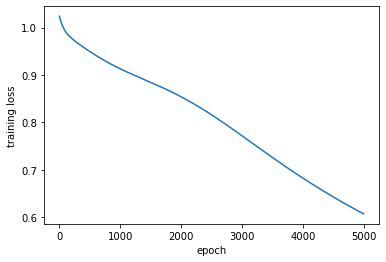

In [79]:
from matplotlib import pyplot as plt
plt.plot(training_loss,'-')
plt.xlabel('epoch')
plt.ylabel('training loss')
plt.show()

#### `torch.nn.functional.relu()` vs `torch.nn.ReLU()`

* `torch.nn.functional.relu()` is a function and expects an argument $x$ 
* `torch.nn.ReLU()` is a functional representation of the former and it does not expect any argument.

### Overfitting, Underfitting and Dropout Layer

When training neural networks, our models are prone to some drowbacks such as overfitting and underfitting. 

* Underfit Model. A model that fails to sufficiently learn the problem and performs poorly on a training dataset and does not perform well on hold-out samples.
* Overfit Model. A model that learns the training dataset too well, performing well on the training dataset but does not perform well on hold-out samples.

Both cases result in a model that does not generalize well. A model with too little capacity cannot learn the problem, whereas a model with too much capacity can learn it too well and overfit the training dataset. While underfitting can easily be addressed by increasing the capacity of the network, overfitting requires the use of specialized techniques. We can recognize overfitting when the model achieves very low error on training data but have a much higher error on the testing data. 

The objective of a neural network is to have a final model that performs well both on the data that we used to train it and the new data on which the model will be used to make predictions. When this is achieved we say that the model learned to generalize well.

In the following example, we will taste overfitting and underfitting using a simple model. Then we will use dropout (we will explain it in detail later on) to soften overfitting.


#### Forcing Overfitting and Underfitting in a Universal Approximator

In [80]:
# set the seed: built-in python, numpy, and pytorch
seed = 172
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed) # works for all devices (CPU and GPU)

In [81]:
num_samples = 256

train_inputs = torch.rand(num_samples)
noise = torch.randn(num_samples)

train_targets = torch.sin(8*train_inputs) + .7*noise

#for validation
valid_inputs = torch.rand(num_samples)
valid_targets = torch.sin(8*valid_inputs) + .7*noise

In [84]:
assert train_inputs[0] != valid_inputs[0]
assert train_targets[0] != valid_targets[0]

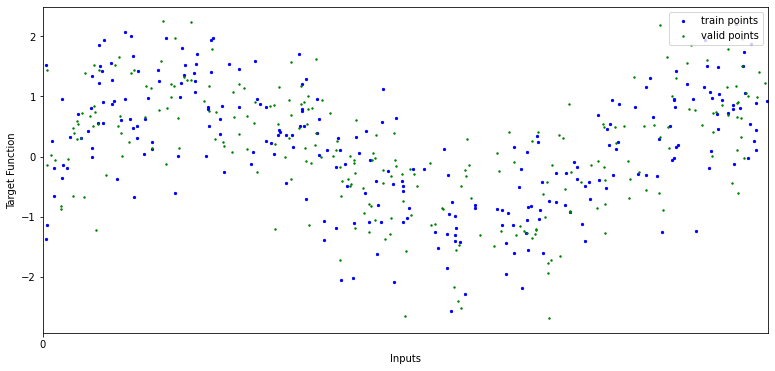

In [85]:
fig, ax = plt.subplots(figsize=(13,6))

ax.scatter(train_inputs, train_targets, c='b', s=5, label='train points')
ax.scatter(valid_inputs, valid_targets, c='g', s=2, label='valid points')
ax.set_xticks(range(0, 1))
plt.xlim(0, 1)
ax.set_xlabel('Inputs')
ax.set_ylabel('Target Function')
#ax.set_title(f'Distribution of sum of two different dices')
ax.legend(loc='upper right')
plt.show()

In [86]:
# DataLoader combines a dataset and a sampler, and provides an iterable over the given dataset. The idea behind the DataLoader is to load 
# your data using multiprocessing (and pinned memory) to asynchronously push your data batch onto the GPU during training so that you can 
# basically hide the data loading time.
# TensorDataset is a convenient method to wrap already loaded tensors into a Dataset.

train_dataloader = DataLoader(TensorDataset(train_inputs, train_targets), batch_size= 256, shuffle=True)
valid_dataloader = DataLoader(TensorDataset(valid_inputs, valid_targets), batch_size= 256, shuffle=True)

In [87]:
class UniversalApprox(nn.Module):
  def __init__(self, num_units, dropout_rate):
    super().__init__()

    self.num_units = num_units
    self.dropout_rate = dropout_rate

    # dropout is a function that takes as input activations from the previous layer and
    # sets some of them at zero, according to the dropout rate value.

    self.dense1 = nn.Linear(1, self.num_units, bias=True)
    self.dense2 = nn.Linear(self.num_units, int(self.num_units), bias=True)
    self.dense3 = nn.Linear(int(self.num_units), int(self.num_units / 2), bias=True)
    self.dense4 = nn.Linear(int(self.num_units/ 2), 1, bias=True)
    self.droput = nn.Dropout2d(p = self.dropout_rate)

  def forward(self, x):
    result = torch.tanh(self.dense1(x))
    result = self.droput(result)
    result = torch.tanh(self.dense2(result))
    result = self.droput(result)
    result = torch.tanh(self.dense3(result))
    result = self.droput(result)
    result = torch.tanh(self.dense4(result))
    return result

Let us define three models:

* model 1: huge model (lot of parameters) with no dropout

* model 2: huge model with dropout activated

* model 3: light model with dropout activated

In [88]:
model_1 = UniversalApprox(num_units = 2048, dropout_rate = .0000001)
model_1.to(device) # load the model on the device (GPU)

model_2 = UniversalApprox(num_units = 2048, dropout_rate = .2)
model_2.to(device)

model_3 = UniversalApprox(num_units = 64, dropout_rate = .2)
model_3.to(device)

model_4 = UniversalApprox(num_units = 8, dropout_rate = .2)
model_4.to(device)

UniversalApprox(
  (dense1): Linear(in_features=1, out_features=8, bias=True)
  (dense2): Linear(in_features=8, out_features=8, bias=True)
  (dense3): Linear(in_features=8, out_features=4, bias=True)
  (dense4): Linear(in_features=4, out_features=1, bias=True)
  (droput): Dropout2d(p=0.2, inplace=False)
)

Let us now see the predictions for each model before training

In [89]:
train_inputs.view(-1,1).size()

torch.Size([256, 1])

We might have the model and data on the GPU, while we want to plot them with matplotlib, which is loaded on the CPU. In this case, we need to transfer these data on the CPU before being able to plot them.

In [90]:
pred_model_1 = model_1(train_inputs.view(-1,1).to(device)).detach().to('cpu')
pred_model_2 = model_2(train_inputs.view(-1,1).to(device)).detach().to('cpu')
pred_model_3 = model_3(train_inputs.view(-1,1).to(device)).detach().to('cpu')

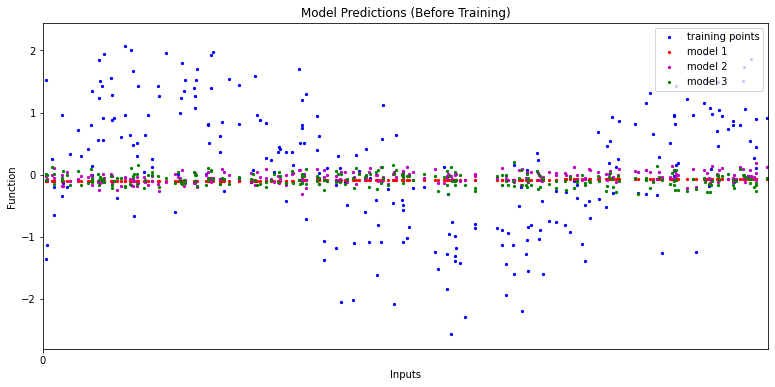

In [91]:
fig, ax = plt.subplots(figsize=(13,6))

ax.scatter(train_inputs, train_targets, c='b', s=5, label='training points')
ax.scatter(train_inputs, pred_model_1, c='r', s=5, label='model 1')
ax.scatter(train_inputs, pred_model_2, c='m', s=5, label='model 2')
ax.scatter(train_inputs, pred_model_3, c='g', s=5, label='model 3')
ax.set_xticks(range(0, 1))
plt.xlim(0, 1)
ax.set_xlabel('Inputs')
ax.set_ylabel('Function')
ax.set_title(f'Model Predictions (Before Training)')
ax.legend(loc='upper right')
plt.show()

Now we define a training function that we will apply to each model. However, we must before explain an important detail. When our models have dropout or batch-normalization layers, it becomes important to specify if the model is in training or evaluation mode. During the former, these layers must be activated while during the latter they must be turned off. 

By default all the modules are initialized to train mode (self.training = True), but from now on we will always esplicitely set the training mode with `model.train()`(it is a good practice). When your model has dropout or batchnorm, you must set `model.eval()` before performing evaluation/inference.

It is worth noticing that `model.train()` and `model.eval()` do not change any behavior of the gradient calculations, but they only change the forward behaviour setting specific layers like dropout and batchnorm to evaluation mode.

In [92]:
def plot_loss(training_loss, validation_loss):
  plt.plot(range(len(training_loss)), training_loss, c='b', label='Loss Training')
  plt.plot(range(len(validation_loss)), validation_loss, c='r', label='Loss Validation')
  plt.ylim(0.4, 0.8)
  plt.show()

Training model_1 ...


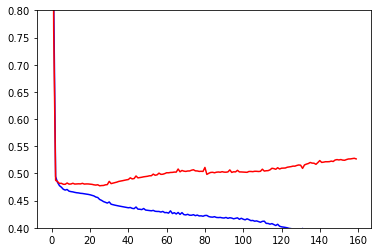

Loss Diff 0.13959681689739228
Training model_2 ...


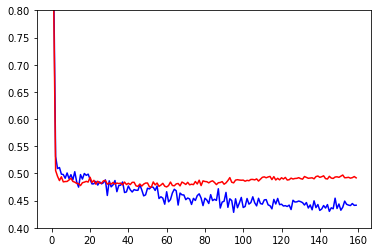

Loss Diff 0.05153472721576691
Training model_3 ...


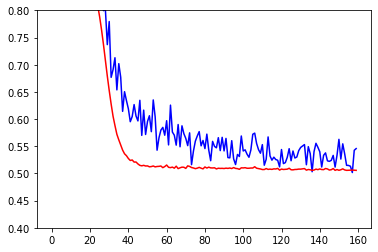

Loss Diff -0.02497050166130066
Training model_4 ...


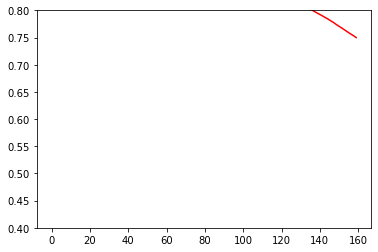

Loss Diff -0.0986430287361145


In [93]:
# Settings
num_epochs = 8000 #3000
learning_rate = 0.0001 #0.001

def training_step(net, criterion, optimizer):
    # set the model to train mode
    net.train()
    for x, y in train_dataloader: # avoid for loop when batch is equal to input data size
      
      # add one dimension
      x = x.view(-1, 1) 
      y = y.view(-1, 1) 

      # transfer to device
      x, y = x.to(device), y.to(device)

      model_pred = net(x)

      loss = criterion(model_pred, y)

      optimizer.zero_grad() # same as model.zero_grad()

      # Backward pass: compute gradient of the loss with respect to model
      # parameters
      loss.backward()

      # Calling the step function on an Optimizer makes an update to its
      # parameters
      optimizer.step()

      return loss.item()

def validation_step(net, criterion, optimizer): #validation step = training step without back-propagation
    # set the model to evaluation mode
    net.eval()
    for x, y in valid_dataloader: # avoid for loop when batch is equal to input data size
      
      # add one dimension
      x = x.view(-1, 1) 
      y = y.view(-1, 1) 

      # transfer to device
      x, y = x.to(device), y.to(device)

      # While, we are performing inference, we don't compute gradients, and thus, don't need to cache these values. 
      # Infact, no graph needs to be create during inference as it will lead to useless consumption of memory.

      with torch.no_grad():
        model_pred = net(x)

        loss = criterion(model_pred, y)

      return loss.item()


model_dict = {'model_1': model_1, 'model_2': model_2, 'model_3': model_3, 'model_4': model_4}


for model in model_dict.keys():
  print('Training {} ...'.format(model))
  criterion = nn.MSELoss(reduction = 'mean')
  optimizer = torch.optim.Adam(model_dict[model].parameters(), lr=learning_rate)

  tr_loss, va_loss = [], []

  for epoch in range(num_epochs):
    tr_loss_step = training_step(model_dict[model], criterion = criterion, optimizer = optimizer)
    if epoch % 50 == 0:
      va_loss_step = validation_step(model_dict[model], criterion = criterion, optimizer = optimizer)
      va_loss.append(va_loss_step)
      tr_loss.append(tr_loss_step)


  plot_loss(tr_loss, va_loss)
  loss_diff = np.array(va_loss)- np.array(tr_loss)
  print('Loss Diff', np.mean(loss_diff[-10:]))

- The first one overfits, and it is clear that there is a huge divergence of training and validation loss functions.
- In the second model, we introduce a dropout and we can immediatly see its effect!
- The third model is the correct one, and we can clearly see it from the plot!
- The last model is way too simple to catch the complexity of the model (which is a sin function).

In [94]:
all_preds = []

for model in model_dict.keys():
  # Disabling gradient calculation is useful for inference, since it will reduce memory 
  # consumption for computations that would otherwise have requires_grad=True.
  with torch.no_grad(): 
    model_dict[model].eval()
    pred = model_dict[model](train_inputs.view(-1,1).to(device)).detach().to('cpu')
    all_preds.append(pred)


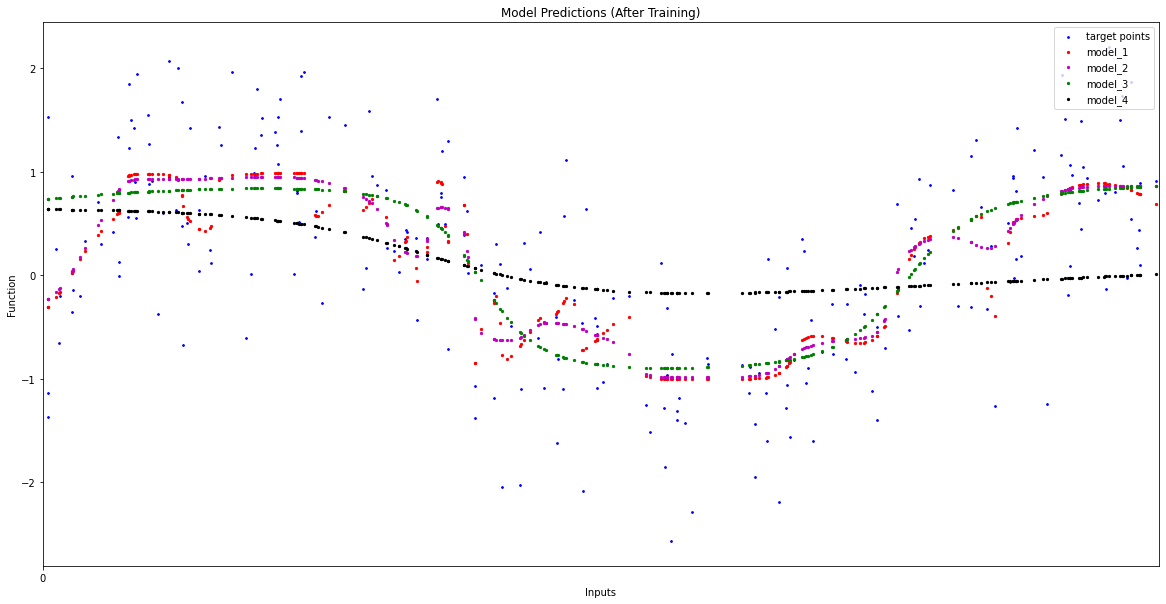

In [95]:
fig, ax = plt.subplots(figsize=(20,10))

#pred_over = np.load('./overfitted_model.npy')
#pred_corr = np.load('./correct_model.npy')

ax.scatter(train_inputs, train_targets, c='b', s=3, label='target points')
for i, model in enumerate(model_dict.keys()):
  colors = ['r', 'm', 'g', 'k']
  ax.scatter(train_inputs, all_preds[i], c=colors[i], s=5, label=model)
  #ax.scatter(inputs, all_preds[1], c='m', s=5, label='model 2')
  #ax.scatter(inputs, all_preds[2], c='g', s=5, label='model 3')

ax.set_xticks(range(0, 1))
plt.xlim(0, 1)
ax.set_xlabel('Inputs')
ax.set_ylabel('Function')
ax.set_title(f'Model Predictions (After Training)')
ax.legend(loc='upper right')
plt.show()

- The last model is too simple to understand the complexity of a sin function.
- The first model learns too many details of the training dataset, since it employs way too many parameters.
- The third model is able to exactly catch the complexity of our model.

The take home messagge is that as the model complexity increases, the models tends to fit even smaller deviations in the training data set. 

Underfitting can easily be addressed by increasing the capacity of the network, for instance the number of layers or parameters. On the other side, overfitting requires the use of specialized techniques that are called regularization techniques. We will now see some common regularizations. We have already used dropout, but let us now see it in detail

### Training, Validation and Test Sets


* **training set:** a set of examples used for learning. It affects parameters and in particular they are optimized according to this set;

* **validation set:** a set of examples not seen by the model during training. It is like a mini-test set that provides feedback to the model during training on how well the current weights generalize beyond the training set. It does not impact or adjust weights directly, but providing information about overfitting it can indirectly impact weights if some regularization techniques are applied. In addition, validation set is widely used to tune hyperparameters;

* **test set:** a set of examples used at the end of training and validation to assess the predictive power of your model.